# Imports

In [1]:
import sys
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sn
import numpy as np

from sklearn.mixture import GaussianMixture
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels
from sklearn.preprocessing import StandardScaler

sys.path.append("../src")

# Constants

In [2]:
train_path = "../data/selected_train.csv"
train_not_norm_path = "../data/train_not_normalized.csv"

# Loading data

In [3]:
take_normalized_data = False

In [4]:
def preprocessing_data(data):
    scaler = StandardScaler()
    scaler.fit(data)
    return scaler.transform(data)

In [5]:
if take_normalized_data:
    # Already preprocessed data
    df_data = pd.read_csv(train_path, sep=",")
    X = df_data[df_data.columns.difference(['label'])].values
    
else:
    # Load data not preprocessed and preprocess it
    df_data = pd.read_csv(train_not_norm_path, sep=",")
    X = df_data[df_data.columns.difference(['label'])].values
    X = preprocessing_data(X)

y = df_data["label"].values

## Train test split

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

In [7]:
print("X_train shape:", X_train.shape)
print("X_test  shape:", X_test.shape)

X_train shape: (20, 56)
X_test  shape: (9, 56)


# GMM
## Define the model

In [8]:
gmm = GaussianMixture(n_components=3, covariance_type='full', max_iter=10_000)

## Fit data

In [9]:
gmm.fit(X_train, y_train)

GaussianMixture(covariance_type='full', init_params='kmeans', max_iter=10000,
                means_init=None, n_components=3, n_init=1, precisions_init=None,
                random_state=None, reg_covar=1e-06, tol=0.001, verbose=0,
                verbose_interval=10, warm_start=False, weights_init=None)

## Test model

In [10]:
y_pred  = gmm.predict(X_test)
y_proba = gmm.predict_proba(X_test)

print("y test:", y_test)
print("y_pred:", y_pred)

y test: [0 0 1 2 1 2 2 1 1]
y_pred: [1 1 1 1 1 1 1 1 1]


## Confusion matrix

In [11]:
cm = confusion_matrix(y_test,y_pred)
cm

array([[0, 2, 0],
       [0, 4, 0],
       [0, 3, 0]])

# GMM after PCA

## PCA over dataset 

In [12]:
from sklearn.decomposition import PCA

In [13]:
pca = PCA(n_components=2)
principalComponents = pca.fit_transform(X)
principalDf = pd.DataFrame(data = principalComponents, columns = ['PC 1','PC 2'])

In [14]:
finalDf = pd.concat([principalDf, df_data[['label']]], axis = 1)

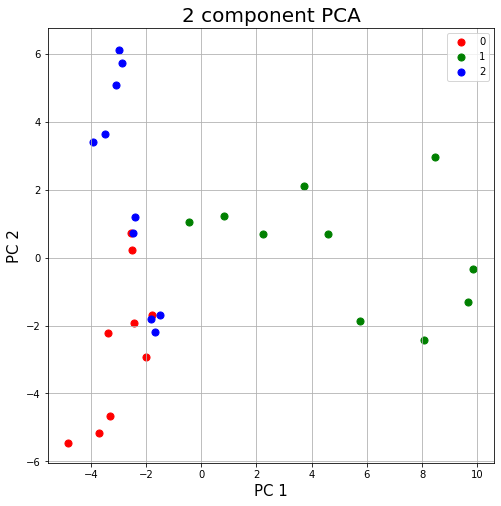

In [15]:
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('PC 1', fontsize = 15)
ax.set_ylabel('PC 2', fontsize = 15)
ax.set_title('2 component PCA', fontsize = 20)
targets = [0, 1, 2]
colors = ['r', 'g', 'b']
for target, color in zip(targets,colors):
    indicesToKeep = finalDf['label'] == target
    ax.scatter(finalDf.loc[indicesToKeep, 'PC 1']
               , finalDf.loc[indicesToKeep, 'PC 2']
               , c = color
               , s = 50)
ax.legend(targets)
ax.grid()

## GMM over 2D PCA

In [16]:
X_pca = finalDf[finalDf.columns.difference(['full_label', 'label'])].values
y_pca = finalDf["label"].values

In [17]:
X_train_pca, X_test_pca, y_train_pca, y_test_pca = train_test_split(X_pca, y_pca, test_size=0.3)

## Fit data from PCA

In [18]:
gmm = GaussianMixture(n_components=3, covariance_type='full', max_iter=10_000, tol=1e-8, init_params="random")

In [19]:
gmm = gmm.fit(X_pca, y_pca)

## Test model

In [20]:
y_pred_pca  = gmm.predict(X_test_pca)
y_proba_pca = gmm.predict_proba(X_pca)

#print("y test:", y_test_pca)
print("y_proba:", y_proba_pca)
print("y", y_pred_pca)
print("y", y_pca)

y_proba: [[4.09941320e-002 9.58741604e-001 2.64263700e-004]
 [1.94138923e-158 9.02073153e-037 1.00000000e+000]
 [9.99694434e-001 3.64984406e-026 3.05565849e-004]
 [2.10912109e-013 9.99999991e-001 8.69007829e-009]
 [1.39015768e-187 2.10495385e-080 1.00000000e+000]
 [9.95646468e-001 4.88122617e-022 4.35353230e-003]
 [9.98086078e-001 6.39623900e-005 1.84996008e-003]
 [3.14285415e-006 9.37802397e-001 6.21944600e-002]
 [9.99804973e-001 2.26303410e-031 1.95027467e-004]
 [9.96437561e-001 1.73799508e-003 1.82444393e-003]
 [8.36196623e-029 2.56931509e-004 9.99743068e-001]
 [9.99135640e-001 6.14659451e-021 8.64359568e-004]
 [9.21865991e-002 9.07414604e-001 3.98797305e-004]
 [5.72386536e-052 3.74557907e-007 9.99999625e-001]
 [4.52006613e-064 1.22913777e-016 1.00000000e+000]
 [3.64058405e-015 7.39374779e-001 2.60625221e-001]
 [1.99026497e-001 8.00809416e-001 1.64086893e-004]
 [9.97272095e-001 1.26854203e-005 2.71521909e-003]
 [9.97781041e-001 1.27248807e-004 2.09171032e-003]
 [9.99658853e-001 5.48

## Confusion matrix

In [43]:
cm = confusion_matrix(y_test_pca, y_pred_pca)

array([[0, 4, 0],
       [0, 0, 1],
       [0, 4, 0]])

## Contour 

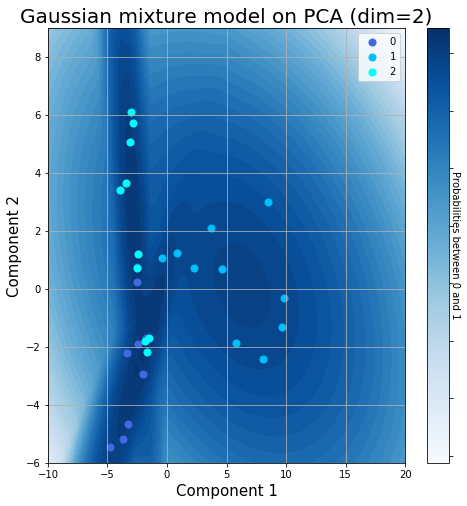

In [135]:
from matplotlib.colors import LogNorm
from matplotlib import ticker, cm
import matplotlib as mpl

targets = [0, 1, 2]
colors = ['royalblue', 'deepskyblue', 'cyan']

fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 

# Contour
X, Y = np.meshgrid(np.linspace(-10, 20), np.linspace(-6, 9))
XX = np.array([X.ravel(), Y.ravel()]).T
Z = gmm.score_samples(XX)


Z = Z.reshape((len(X),len(Y)))
ax.contourf(X, Y, Z, levels=40,cmap=cm.Blues)

for target, color in zip(targets,colors):
    indicesToKeep = finalDf['label'] == target
    ax.scatter(finalDf.loc[indicesToKeep, 'PC 1']
               , finalDf.loc[indicesToKeep, 'PC 2']
               , c = color
               , label = target
               , s = 50)

ax.set_xlabel('Component 1', fontsize = 15)
ax.set_ylabel('Component 2', fontsize = 15)
ax.set_title('Gaussian mixture model on PCA (dim=2)', fontsize = 20)
ax.legend()
ax.grid()
#legend

cbar = plt.colorbar(heatmap)
cbar.ax.set_yticklabels([])
cbar.set_label('Probabilities between 0 and 1', rotation=270)
#cbar.ax.get_yaxis().set_ticks([])
plt.show()